### **Movies - Images and Text -- Assignment [10pts]**

In this assignment, we will be dealing with a significantly larger and more realistic dataset consisting of both images and text. For this assignment we will use the MMIMDB dataset (https://github.com/johnarevalo/gmu-mmimdb), collected by Arévalo, González, Solorio and Montes-y-Gómez from the Universidad Nacional de Colombia, University of Houston, INAOE-México. This dataset contains data corresponding to ~26,000 movies along with their plots (text) and their movie posters (images), and other information such as ratings and genres (categories). These are more movies than we will watch in a lifetime. We will use this dataset for movie genre classification. Each movie can be labeled with 27 categories of movies.

#### **1. Loading and Exploring the Dataset.**

##### **1.1 Dataset Download and Extraction**

First, we download the dataset, then we will create a Dataset class to load both the input movie posters (images), and input movie plots (texts), and the target movie genres (labels). We will also integrate the BertTokenizer from the huggingface transformers library so that the texts are pre-tokenized as they are loaded. The images however will be loaded on the fly as they can not all fit into memory.

In [1]:
!wget -nc http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
#!wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
# I found downloading from Google Drive with gdown is a lot faster.
!pip -q install gdown
#!gdown https://drive.google.com/uc?id=173IhB80sQj2QfzTa10EsoUeEirb7LLlE
!tar xf mmimdb-256.tar.gz
#!tar xf mmimdb-512.tar.gz # I also keep a copy with images resized at 512 pixels on their largest side.
!pip install livelossplot --quiet
!pip -q install transformers

--2022-02-28 01:32:24--  http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz [following]
--2022-02-28 01:32:24--  https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643479473 (614M) [application/x-gzip]
Saving to: ‘mmimdb-256.tar.gz’

mmimdb-256.tar.gz   100%[===================>] 613.67M  3.19MB/s    in 3m 14s  

2022-02-28 01:35:38 (3.16 MB/s) - ‘mmimdb-256.tar.gz’ saved [643479473/643479473]

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 6.8 MB 38.1 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████

##### **1.2 Defining the Data Loader**
This is a typical step in your course project that you will need to complete. Find some dataset, define your task, then get to know your data well enough so that you can write a data loader for it. Don't take this work for granted. It is hard work. Please take some time analyzing the code below and if you have questions feel free to ask on Piazza. Play especially close attention to the part of the code used for tokenizing the text. This is a special preprocessing step in NLP that doesn't typically apply to images.

In [2]:
import torch, os, json
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from PIL import Image

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset-resized-256max', split = 'dev',
                 image_transform = None):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Pre-tokenizing all sentences.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            self.tokenized_plots.append(encoded_text)
        print(' finished')
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        text = self.tokenized_plots[index]['input_ids'][0]
        text_mask = self.tokenized_plots[index]['attention_mask'][0]
        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        return image, text, text_mask, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished
Data size: 2608 samples


##### **1.3 Testing the data loader**
Printing one element from this dataset, both the plot, movie poster, labels, and some of the other metadata. Do not move to the following cells until you understand every line in the code above and below.

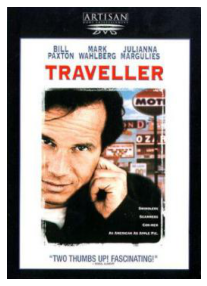

['a', 'young', 'man', ',', 'pat', ',', 'visits', 'the', 'clan', 'of', 'gypsy', '-', 'like', 'gr', '##if', '##ters', '(', 'irish', 'travellers', ')', 'in', 'rural', 'north', 'carolina', 'from', 'whom', 'he', 'is', 'descended', '.', 'he', 'is', 'at', 'first', 'rejected', ',', 'but', 'cousin', 'bo', '##kk', '##y', 'takes', 'him', 'on', 'as', 'an', 'apprentice', '.', 'pat', 'learns', 'the', 'game', 'while', 'bo', '##kk', '##y', 'falls', 'in', 'love', 'and', 'desires', 'a', 'different', 'life', '.']
a young man , pat , visits the clan of gypsy - like grifters ( irish travellers ) in rural north carolina from whom he is descended . he is at first rejected , but cousin bokky takes him on as an apprentice . pat learns the game while bokky falls in love and desires a different life .
['Crime', 'Drama', 'Romance']
Title:  Traveller
Kind:  movie
Year:  1997
Rating:  6.2


In [29]:
import numpy as np

sample_movieID = 1247
img, text, text_mask, labels = val_data[sample_movieID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show input plot (untokenized).
tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
print(tokens)
print(val_data.tokenizer.convert_tokens_to_string(tokens))

# Show target labels (converted back to strings from binary vector).
labels = labels.numpy()
# Is there a better way to do this?
print([val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

# You can look at other attributes for the movies on this dataset.
movie_metadata = val_data.get_metadata(sample_movieID)
print('Title: ', movie_metadata['smart canonical title'])
print('Kind: ', movie_metadata['kind'])
print('Year: ', movie_metadata['year'])
print('Rating: ', movie_metadata['rating'])

##### **1.4 Visualizing a group of samples**
We explore below some of the images in the dataset that belong to the category `Comedy`.

There are 873 movies of type Comedy among 2608


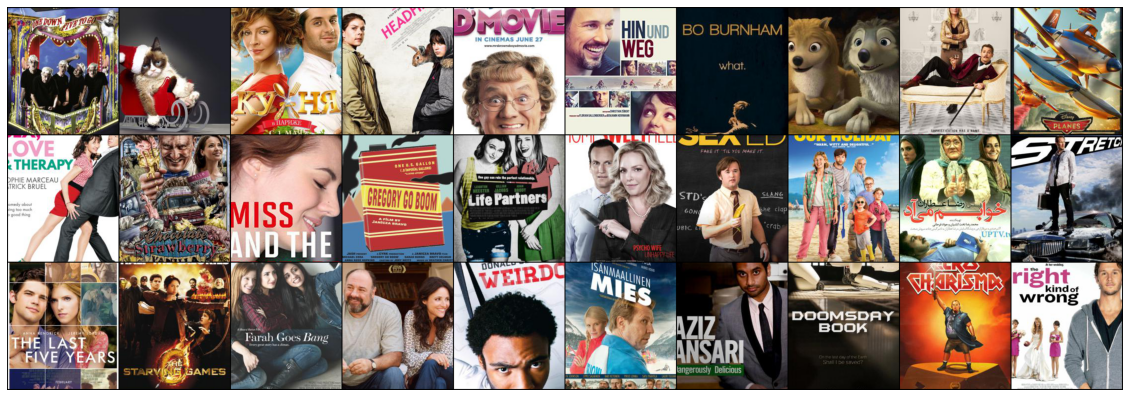

In [30]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

# Now let's display a bunch of posters for Crime movies.
movieType = 'Comedy'
crime_ids = [id for id in range(0, len(val_data)) \
             if movieType in set(val_data.get_metadata(id)['genres'])]

print('There are %d movies of type %s among %d' % 
      (len(crime_ids), movieType, len(val_data)))

def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

# I'm passing the ids in reverse order, because it seems the movies are
# ordered from old to new in the dataset. Try the other way.
show_image_group(val_data, crime_ids[::-1], 30)

#### **2. Classify the Movies into Genres (based on their Plots -- Text) [2pts]**

For this assignment we will not just use BERT encodings but we will use a pretrained BERT model and "fine-tune" its parameters to they adapt to the text in this dataset. This is commonly referred as transfer learning. You can try compare it to a simpler bag-of-words model but this is left as an exercise on your own.

##### **2.1. Setting up Data Loaders**

In the code below, we are loading the training, and validation splits and then testing the batch loaders.

In [31]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ... finished
Tokenizing... finished
Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


Testing what a sample batch looks like.

In [32]:
(imgs, texts, text_masks, labels) = next(iter(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27])


##### **2.2. Loading the predefined BERT Transformer Model**

Here we initialize the pretrained BERT model from the huggingface transformers library. They have several slightly different versions of it that are slightly modified for different tasks so you don't need to manually modify it (e.g. replacing last layer with something else) for your particular task. Do not be surprised if Google Colab keeps crashing. This is a very heavy model so I would recommend only running this cell once. Or if you have to run it twice, you might have to restart the runtime.

In [33]:
from transformers import BertForSequenceClassification, BertConfig

# Loading BERT...
num_categories = len(trainset.categories)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)

# Let's run a quick test on this model on the CPU.
output = model(texts, text_masks)
print(output.logits.shape)

# Tell pytorch to run this model on the GPU.
model.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

torch.Size([10, 27])


##### **2.3. Training Loop for finetuning this BERT Model**
Not very different than a training loop for training a model based on convolutional neural networks. However, please pay close attention to the differences. 

In [ ]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 4

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# Training Loop. 
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples    
            liveloss.update(logs, current_step)
            liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth') 

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### **2.4. Loading model weights from a file**
Training the model in the previous section might take about an hour -- instead we can load a model that has been pretrained already. Feel free to retrain but here I provide a model I trained myself by running the code in the preceding section.

In [34]:
# I uploaded a "checkpoint" of this model that I trained on Google Drive.
# Try saving and uploading your model to Google Drive as well.
#!gdown https://drive.google.com/uc?id=1WuLFvQLMd0_Nmpjp7aDRIovWtOiRRyRd
#model = torch.load('/content/drive/MyDrive/Colab Notebooks/best_model_so_far-comp646-spring2022 (1).pth')
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/best_model_so_far-comp646-spring2022 (1).pth'))

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

##### **2.5 Show the predictions for a few input texts [1pt]**
Show the top five classification predictions of the BERT model for a few input plots, as shown below. In order to obtain probability scores you need to understand what the nn.BCEWithLogitsLoss is doing when training the prediction scores. Take into account that since we are dealing with multi-class classification, this is not a softmax classifier trained with a cross entropy loss (nn.CrossEntropyLoss), ie. prediction scores don't add up to 1.

In [43]:
review_text = "this biopic follows rommel ' s career after the afrika korps , including his work on the defenses of fortress europe as well as his part in the assassination attempt on hitler , and his subsequent suicide ."
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_text = tokenizer.encode_plus(
                review_text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')

text = encoded_text['input_ids'][0]
text_mask = encoded_text['attention_mask'][0]

texts_pred = text.to(device='cuda').unsqueeze(0)
text_masks_pred = text_mask.to(device='cuda').unsqueeze(0)

predicted = model(texts_pred, text_masks_pred)
sorted_vals, sorted_ids = predicted.logits.data.sigmoid().sort(dim = 1, descending = True)
top_pred_vals = sorted_vals[:, :5].to('cpu').numpy() 
top_ids = sorted_ids[:, :5].to('cpu').numpy()
categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

for i in range(0,5):
  cat = top_ids[0][i]
  print("P[" + categories[cat] +"] = " + str(round(top_pred_vals[0][i],2)))

P[War] = 0.92
P[Drama] = 0.89
P[History] = 0.78
P[Biography] = 0.44
P[Action] = 0.24


##### **2.6. Show the posters for movies labeld as Comedy with the highest confidence by the BERT model. [1pt]**

Use the show_image_group function provided earlier to show the top 30 images scored with the highest scores by the BERT model as Comedy. **Note:** I know the model is not scoring the movies based on the movie poster at all but it seems easier to judge by movie poster for a quick visual inspection as it doesn't require reading text.

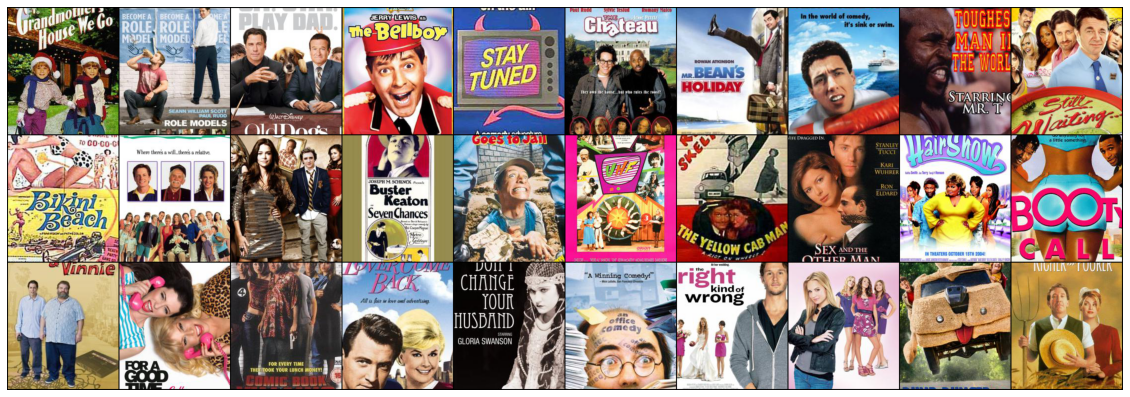

In [44]:

model.eval()

pred_dict = {}

import numpy as np
for i in range(len(valset)):
  
  image, text, text_mask, label_vector = valset[i]

  texts_pred = text.to(device='cuda').unsqueeze(0)
  text_masks_pred = text_mask.to(device='cuda').unsqueeze(0)

  predicted = model(texts_pred, text_masks_pred)
  sorted_vals, sorted_ids = predicted.logits.data.sigmoid().sort(dim = 1, descending = True)

  top_pred_vals = sorted_vals[:, :1].to('cpu').numpy() 
  top_ids = sorted_ids[:, :1].to('cpu').numpy() 

  if categories[top_ids[0][0]] == 'Comedy':
    pred_dict[i] = top_pred_vals[0][0]

sorted_dict_bert = dict(sorted(pred_dict.items(), key=lambda item: item[1], reverse = True))

  
def show_image_group(dataset, image_ids, n_images):

    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));


show_image_group(valset, list(sorted_dict_bert.keys()), 30)

#### **3. Classify the Movies into Genres (based on their Posters -- Images) [4pts]**



Feel free to discuss answers to these questions or share plots on Piazza -- but not code. Also I'm setting here a leaderboard again for this task [here](https://docs.google.com/spreadsheets/d/1p7ly7-VC3WiI5mtsy-xKfHVu8cwaYK1Eovmysfnasws/edit?usp=sharing). Please share your results so that your classmates know where their solution lies with respect to the rest of the class.

##### **3.1 Training the model [2pts]**
For this part feel free to re-use code from the previous sections, the previous assignment, and the previous assignment solutions, as appropriate. You have to at least show your training/validation accuracy and loss plots showing the model is learning and has converged.

In [45]:
import time

In [46]:
#!pip install cnn_finetune
import torchvision.models as models
import torch.nn as nn


model_ft = models.resnet18(pretrained=True)
model_ft.fc.requires_grad = True

model_ft.fc=nn.Linear(in_features=512, out_features=27)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [48]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

# Are the top five scored labels accurate?
def top_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# Defining as global the device to use (by default CPU).
#device = torch.device("cuda")
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu') 
print ('Using device:', device)
#current_step = 0

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model,   #this is called model_ft
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses() 
  current_step = 0

  for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.to(device)  #cuda()
        text_masks = text_masks.to(device)   #.cuda()
        labels = labels.to(device)   #.cuda()
        imgs = imgs.to(device)

        # Compute predictions.
        predicted = model(imgs)

        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top_accuracy(predicted, labels).sum().item()
        num_samples += imgs.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # Move to GPU.
        texts = texts.to(device)  #.cuda()
        text_masks = text_masks.to(device)   #.cuda()
        labels = labels.to(device)    #.cuda()
        imgs =  imgs.to(device)

        # Compute predictions.
        predicted = model(imgs)

        # Compute loss.
        loss = cost_function(predicted, labels)

      #         # Compute loss.
      # #loss = cost_function(predicted, yb)
      # cumulative_loss += loss.item()

      # # Count how many correct in batch.
      # predicted_ = predicted.detach().softmax(dim = 1)
      # max_vals, max_ids = predicted_.max(dim = 1)
      # correct += (max_ids == yb).sum().cpu().item()
      # n_samples += xb.size(0)

        # Compute cumulative loss and top-5 accuracy.
        #cumulative_loss += loss.item()
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top_accuracy(predicted, labels).sum().item()
        num_samples += imgs.size(0)

        if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples    
            liveloss.update(logs, current_step)
            liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far_section3.pth') 

count_params = 0
for param in model_ft.parameters():
 count_params += param.numel()
print(count_params)

Using device: cuda
11190363


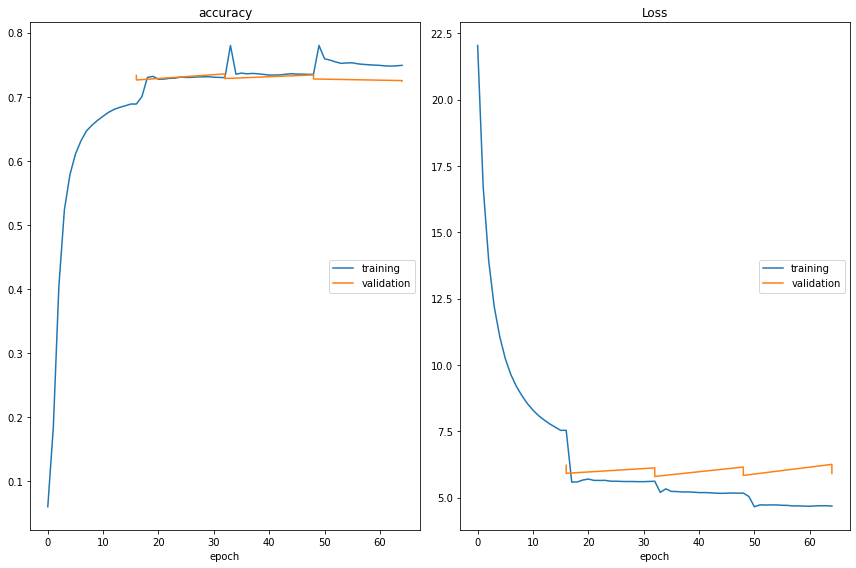

accuracy
	training         	 (min:    0.060, max:    0.780, cur:    0.749)
	validation       	 (min:    0.724, max:    0.736, cur:    0.724)
Loss
	training         	 (min:    4.657, max:   22.036, cur:    4.683)
	validation       	 (min:    5.799, max:    6.254, cur:    5.909)
--- 283.929705619812 seconds ---


In [49]:
# Your training code goes here.

batch_size = 16
n_epochs = 130
learningRate = 1e-4

#cost_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(pretrainedModel.parameters(), lr=0.0001)

num_epochs = 4

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model_ft.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

start_time = time.time()

train_model(batch_size, n_epochs, learningRate, model_ft, cost_function, optimizer, -1, train_loader, val_loader);

end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))



**Required answer:** Is this model better than the text classifier in terms of top-5 accuracy as computed earlier? Which one is better?

**Ans:** The image classifier model almost performs the same as the text classifier though the text classifier performs slightly better - as seen from the accuracy obtained. This concludes that though image classifiers are more powerful, using BERT for text classification gives us good results.

##### **3.2 Analysis [0.5pt]**
Show the images classified as "Comedy" with the highest confidence using the above image classifier (show their posters).

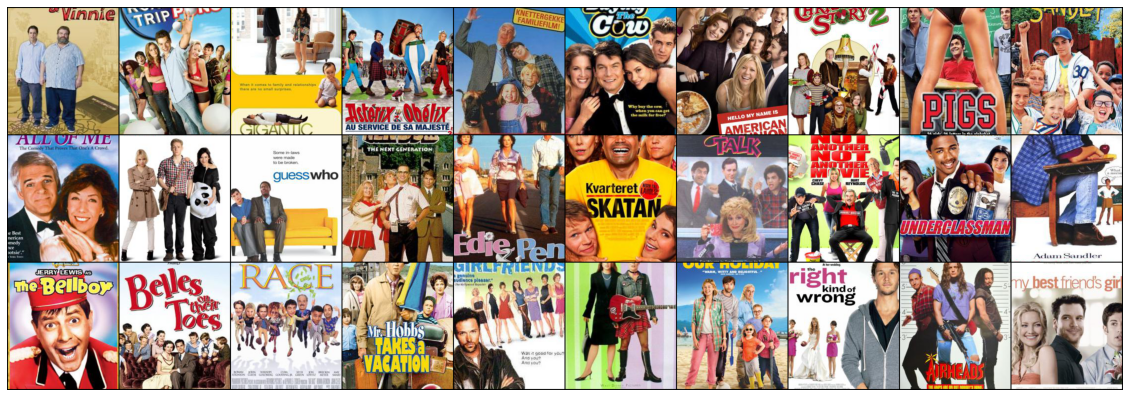

In [50]:
# Your code goes here.
model_ft.eval()

pred_dict = {}

import numpy as np
for i in range(len(valset)):
  
  image, text, text_mask, label_vector = valset[i]

  img = image.to(device = 'cuda').unsqueeze(0)
 

  predicted = model_ft(img)
  sorted_vals, sorted_ids = predicted.softmax(dim = 1).sort(descending = True)
  #print(sorted_vals)
  top_pred_vals = sorted_vals[:, :].to('cpu').detach().numpy() 
  top_ids = sorted_ids[:, :].to('cpu').numpy() 

  #print(top_ids)
  if categories[top_ids[0][0]] == 'Comedy':
    
    pred_dict[i] = top_pred_vals[0][0]

sorted_dict_resnet = dict(sorted(pred_dict.items(), key=lambda item: item[1], reverse = True))


def show_image_group(dataset, image_ids, n_images):

    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));


show_image_group(valset, list(sorted_dict_resnet.keys()), 30)

##### **3.3 Show Predictions [0.5pt]**
For a given movie, show its plot, poster, and the predictions of the plot classifier and the poster classifier.

Stage Door
The plot of the given movie is: ["Terry Randall, rich society beauty, has decided to see if she can break into the Broadway theatre scene without her family connections. She goes to live in a theatrical boarding house and finds her life caught up with those of the other inmates and the ever-present disappointment that theatrical hopefuls must live with. Her smart-mouth roommate, Jean, is approached by a powerful producer for more than just a role. And Terry's father has decided to give her career the shove by backing a production for her to star in, in which she's sure to flop. But his machinations hurt more than just Terry.", 'The Footlights Club is a women\'s theatrical rooming house in New York City. It is the residence for many a struggling actress, most who can barely make ends meet, hence the reason that they decide to live in the inexpensive club with cramped quarters, shared bathroom and the bad lamb stew for dinners. Elderly Catherine Luther lives there solely to be

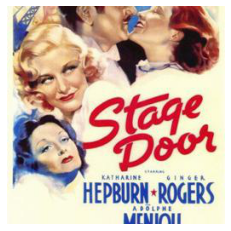

In [51]:
# Your code goes here.
index = 100
movie = valset.get_metadata(index)
movie_plot = movie['plot']
print(movie['title'])
print("The plot of the given movie is:", movie_plot)

#displaying movie poster
Transf = transforms.Compose([transforms.CenterCrop((256, 256)), transforms.ToTensor()])
img = Transf(valset.load_image_only(index)) 
plt.imshow(F.to_pil_image(img));plt.axis(False)


# Predictions of plot classifier
review_text = movie_plot
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_text = tokenizer.encode_plus(
                review_text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')

text = encoded_text['input_ids'][0]
text_mask = encoded_text['attention_mask'][0]

texts_pred = text.to(device='cuda').unsqueeze(0)
text_masks_pred = text_mask.to(device='cuda').unsqueeze(0)

predicted = model(texts_pred, text_masks_pred)
sorted_vals, sorted_ids = predicted.logits.data.sigmoid().sort(dim = 1, descending = True)
top_pred_vals = sorted_vals[:, :].to('cpu').numpy() 
top_ids = sorted_ids[:, :].to('cpu').numpy()
categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

for i in range(0,len(categories)):
  cat = top_ids[0][i]
  print("P[" + categories[cat] +"] = " + str(round(top_pred_vals[0][i],2)))


In [52]:
# Predictions of poster classifier

from numpy.core.fromnumeric import shape
from torch import cuda
from torchvision.transforms.functional import to_tensor

tf=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor()   #ToDTensor()
])

Img, text, text_mask, label = valset[index]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# img, labels = img.cuda, labels.cuda

img1 = tf(Img).unsqueeze(0)
img1 = img1.to(device)
# print(type(img1))
model_ft.eval()
with torch.no_grad():
  # ar=sm.cpu()
  # gg=ar.detach().numpy()
  pr  = model_ft(img1)  #.cpu()
  prediction = pr.softmax(dim=1)
  #print("prediction",prediction)

for i in range(0, len(trainset.categories)):
  score = prediction[0, i].item()
  category = trainset.categories[i]
  print('p("{0}") = {1:.2f}'.format(category, score))

p("Action") = 0.00
p("Adult") = 0.00
p("Adventure") = 0.00
p("Animation") = 0.02
p("Biography") = 0.02
p("Comedy") = 0.27
p("Crime") = 0.01
p("Documentary") = 0.12
p("Drama") = 0.29
p("Family") = 0.01
p("Fantasy") = 0.01
p("Film-Noir") = 0.00
p("History") = 0.02
p("Horror") = 0.01
p("Music") = 0.01
p("Musical") = 0.02
p("Mystery") = 0.01
p("News") = 0.00
p("Reality-TV") = 0.00
p("Romance") = 0.10
p("Sci-Fi") = 0.01
p("Short") = 0.04
p("Sport") = 0.00
p("Talk-Show") = 0.00
p("Thriller") = 0.00
p("War") = 0.01
p("Western") = 0.00


##### **3.3 Further Analysis [1pt]**
 Is there an overlap in the top 100 images rated as Comedy by the text classifiers and the image classifier? How big is this overlap?

Number of overlapped images: 20
Visualization of overlapped images:


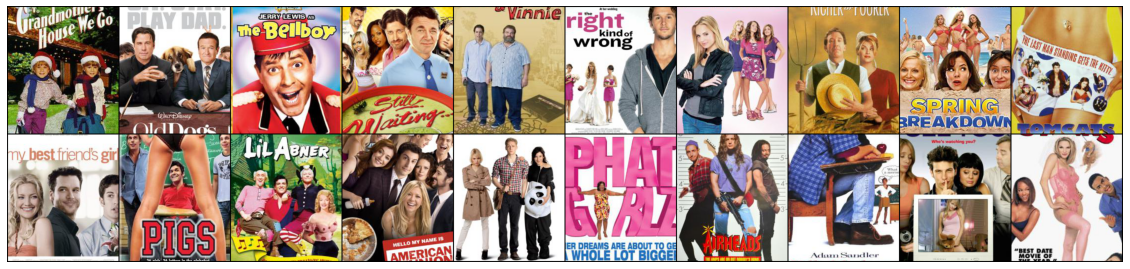

In [55]:
# Compute the overlap here.
bert_top_100 = list(sorted_dict_bert.items())[:100]
resnet_top_100 = list(sorted_dict_resnet.items())[:100]

bert_ids = [pred[0] for pred in bert_top_100]
resnet_ids = [pred[0] for pred in resnet_top_100]

overlap = 0

overlapped_ids = []

for i in bert_ids:
  if i in resnet_ids:
    overlap += 1
    overlapped_ids.append(i)
print("Number of overlapped images:", overlap)

print("Visualization of overlapped images:")
def show_image_group(dataset, image_ids):

    #image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

show_image_group(valset, overlapped_ids)


As seen from the computation, the overlap for these models is 20 ~ 20%. This is understandable as the accuracy is almost the same and is about 70%-75% for these models.

#### **4. Multimodal Models (Text + Images) [4pts]**

##### **4.1 Late-fusion Model**

Below I define a multimodal model that can be potentially trained with both images and text. It combines the outptus of a text model and an image model and concatenates them before passing them through a final linear layer.

In [36]:
from transformers import BertModel, BertConfig

class MultiModalMovieModel(torch.nn.Module):
    def __init__(self):
        super(MultiModalMovieModel, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased',   
                                    output_attentions = False,  
                                    output_hidden_states = True)
        
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (5, 5), stride = 4)
        self.conv2 = torch.nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.linear1 = torch.nn.Linear(in_features = 32 * 3 * 3, out_features = 256)
        self.linear2 = torch.nn.Linear(in_features = 256 + 768, out_features = 20)

    def forward(self, img, text, text_mask):

        # Compute the text feature outputs out of the BERT model.
        text_features = self.bert(text, text_mask).pooler_output

        # First conv layer + maxpool2d + relu.
        x = self.conv1(img)
        x = torch.nn.functional.max_pool2d(x, (4, 4))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        x = x.view(x.size(0), -1)
        print(x.shape)
        # Pass through linear layers.
        image_features = self.linear1(x)

        # Cobmine the image and text features through concatenation.
        combined_features = torch.cat((image_features, text_features), 1)

        # Pass the combined features thorugh a linear layer and output.
        x = torch.nn.functional.relu(combined_features)
        x = self.linear2(x)
        print(x.shape)
        return x

# Sample input data.
img, text, text_mask, labels = next(iter(val_loader))

# Create model.
my_model = MultiModalMovieModel()

# Make predictions.
predictions = my_model(imgs, texts, text_masks)

# This shouldn't print any errors.
print(imgs.shape, texts.shape, text_masks.shape, labels.shape, predictions.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([10, 288])
torch.Size([10, 20])
torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27]) torch.Size([10, 20])


##### **4.2 FiLM: Feature-wise Linear Modulation [4pts]**

In 2017 a paper was written by Ethan Perez, an undergraduate student at Rice University, and collaborators at other institutions. This paper has been influential in work combining outputs from two modalities. Instead of just combining the outputs of each modality at the end -- they propose to combine them across several layers in the middle. To earn points here you need to read the paper and modify the neural network below so that it uses the technique described in this work: https://arxiv.org/pdf/1709.07871.pdf. You can also read a more friendly introduction to this technique here: https://distill.pub/2018/feature-wise-transformations/ and here: https://ml-retrospectives.github.io/neurips2019/accepted_retrospectives/2019/film/

Concretely, modify the network below so that instead of late-fusion using concatenation-based fusion, the text_features are used for feature-wise modulation of the outputs of the second convolutional layer. Please provide your own implementation for the required operation in FiLM. It doesn't need to be general -- as long as it works for this particular instance.

In [37]:
from transformers import BertModel, BertConfig

class MultiModalMovieModel(torch.nn.Module):
    def __init__(self):
        super(MultiModalMovieModel, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased',   
                                    output_attentions = False,  
                                    output_hidden_states = True)
        
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (5, 5), stride = 4)
        self.conv2 = torch.nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.linear2 = torch.nn.Linear(in_features = 288, out_features = 27)
        self.linear3 = torch.nn.Linear(in_features=768, out_features=288)
        self.linear4 = torch.nn.Linear(in_features=768, out_features=288)

    def forward(self, img, text, text_mask):

        # Compute the text feature outputs out of the BERT model.
        text_features = self.bert(text, text_mask).pooler_output

        # First conv layer + maxpool2d + relu.
        x = self.conv1(img)
        x = torch.nn.functional.max_pool2d(x, (4, 4))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        x = x.view(x.size(0), -1)
        #print(x.shape)
        # Pass through linear layers
        gamma = self.linear3(text_features)
        beta = self.linear4(text_features)
        # Cobmine the image and text features through concatenation.
        combined_features = gamma*x + beta
        # Pass the combined features thorugh a linear layer and output.
        x = torch.nn.functional.relu(combined_features)
        #print(x.shape)
        x = self.linear2(x)

        return x

# Sample input data.
img, text, text_mask, labels = next(iter(val_loader))

# Create model.
my_model = MultiModalMovieModel()

# Make predictions.
predictions = my_model(imgs, texts, text_masks)

# This shouldn't print any errors.
print(imgs.shape, texts.shape, text_masks.shape, labels.shape, predictions.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27]) torch.Size([10, 27])


In [38]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

# Are the top five scored labels accurate?
def top_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# Defining as global the device to use (by default CPU).
#device = torch.device("cuda")
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu') 
print ('Using device:', device)
#current_step = 0

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model,   #this is called model_ft
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses() 
  current_step = 0

  for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.to(device)  #cuda()
        text_masks = text_masks.to(device)   #.cuda()
        labels = labels.to(device)   #.cuda()
        imgs = imgs.to(device)

        # Compute predictions.
        predicted = model(imgs, texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top_accuracy(predicted, labels).sum().item()
        num_samples += imgs.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # Move to GPU.
        texts = texts.to(device)  #.cuda()
        text_masks = text_masks.to(device)   #.cuda()
        labels = labels.to(device)    #.cuda()
        imgs =  imgs.to(device)

        # Compute predictions.
        predicted = model(imgs, texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted, labels)

      #         # Compute loss.
      # #loss = cost_function(predicted, yb)
      # cumulative_loss += loss.item()

      # # Count how many correct in batch.
      # predicted_ = predicted.detach().softmax(dim = 1)
      # max_vals, max_ids = predicted_.max(dim = 1)
      # correct += (max_ids == yb).sum().cpu().item()
      # n_samples += xb.size(0)

        # Compute cumulative loss and top-5 accuracy.
        #cumulative_loss += loss.item()
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top_accuracy(predicted, labels).sum().item()
        num_samples += imgs.size(0)

        if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples    
            liveloss.update(logs, current_step)
            liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far_section3.pth') 

count_params = 0
for param in my_model.parameters():
 count_params += param.numel()
print(count_params)

Using device: cuda
109979611


In [39]:
import time

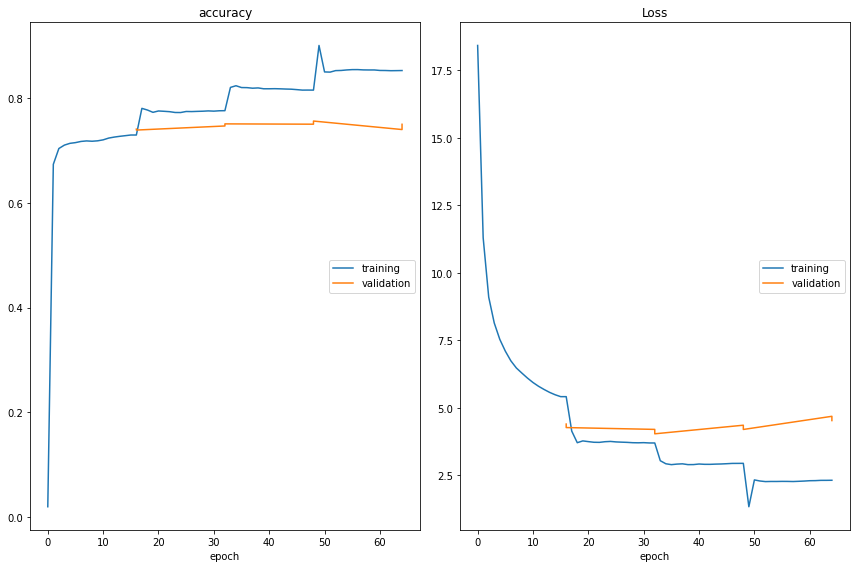

accuracy
	training         	 (min:    0.020, max:    0.900, cur:    0.852)
	validation       	 (min:    0.739, max:    0.756, cur:    0.750)
Loss
	training         	 (min:    1.337, max:   18.418, cur:    2.317)
	validation       	 (min:    4.038, max:    4.686, cur:    4.528)
--- 2014.467413187027 seconds ---


In [40]:
# Your training code goes here.

batch_size = 16
n_epochs = 130
learningRate = 1e-4

#cost_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(pretrainedModel.parameters(), lr=0.0001)

num_epochs = 4

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(my_model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

start_time = time.time()

train_model(batch_size, n_epochs, learningRate, my_model, cost_function, optimizer, -1, train_loader, val_loader);

end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))


In [56]:
#!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('am214_assignment002.ipynb')





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/am214_assignment002.ipynb to pdf
[NbConvertApp] Support files will be in am214_assignment002_files/
[NbConvertApp] Making directory ./am214_assignment002_files
[NbConvertApp] Making directory ./am214_assignment002_files
[NbConvertApp] Making directory ./am214_assignment002_files
[NbConvertApp] Making directory ./am214_assignment002_files
[NbConvertApp] Making directory ./am214_assignment002_files
[NbConvertApp] Making directory ./am214_assignment002_files
[NbConvertApp] Making directory ./am214_assignment002_files
[NbConvertApp] Making directory ./am214_assignment002_files
[NbConvertApp] Writing 166061 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF succ

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'